---
# Module 8, Part 1: Forecasting With Pandas

---
# Introduction

In this module we discuss how to deal with temporal data, data-sets with a time component. Without `pandas`, simply syncing times for different data sets can become into its own data preparation problem. In this module we will side step this problem. 

This module will cover the following key topics.

* Forecasting
* Time Series
* Pandas for Time Series

Our emphasis will be on reproducible and testable forecasting methods that have been shown to work, and the terms and concepts required for understanding them.
This module consists of 2 parts.

* Part 1 - Forecasting with Pandas
* Part 2 - Time Series

Each part is provided in a separate file. It is recommended that you follow the order of the files.

---
# Learning Outcomes

* Develop familiarity with basic forecasting techniques and methods
* Understand how Pandas supports working with time series data
* Gain experience working with time series data in Pandas
* Practice downloading stock information and calculating returns 

---
# Readings and Resources

The majority of the notebook content draws from the recommended readings. We invite you to further supplement this notebook with the following recommended texts.

* Hyndman, R.J. & Athanasopoulos, G. (2018). _Forecasting: principles and practice, 2nd Ed._  [online](https://www.otexts.org/fpp2)
    * Chapter 1: Getting started
    * Chapter 2: Time series graphics
    * Chapter 3: The forecaster's toolbox
    * Chapter 6.1: Time series components

---

---
# Setup

To begin, we will import the following code. Note that the code should be ignored in this module, because we haven't gone over the necessary concepts to understand the code present.

We recommend inspecting the code in this part after going through both parts of the module.

In [2]:
import numpy as np  # For computations
import pandas as pd  # For indexing our data

np.random.seed(12345)
import matplotlib.pyplot as plt  # for visualizing our data

plt.style.use(style='ggplot')
plt.rc('figure', figsize=(10, 6))
PREVIOUS_MAX_ROWS = pd.options.display.max_rows
pd.options.display.max_rows = 20
np.set_printoptions(precision=4, suppress=True)

# Our temporal data types
from datetime import datetime
from datetime import timedelta

# For grabbing data sets
import requests

# For hiding code blocks, as they aren't necessary at this point
from IPython.display import HTML

---
# Forecasting

**Forecasting** is about predicting future events as accurately as possible. Predictions (in the form of a time series) are an important aid for effective and efficient planning. Often a key step is knowing when something can be forecast accurately, and when forecasts will be no better than random chance. Good forecasts capture patterns / relationships in the historical data, without replicating past events that are unlikely to reoccur.

There are two types of forecasting.

* **Cross-sectional forecasting**
* **Time series forecasting**

Cross-sectional forecasting is an observational analysis from a population, or a representative subset, at *a specific point in time*. In this module, cross-sectional forecasting will not in the scope of our discussion. We will primarily focus on time series forecasting. We will touch upon cross-sectional forecasting when discussing regression in a later module.

In contrast, time series forecasting uses only information on the variable(s) to be forecast, and makes no attempt to discover additional factors which affect its behavior.

---
## Application

The predictability of an event or a quantity depends on several factors.

* how well we understand the factors contributing to the quantity
* how much data is available
* how past forecasts can affect future forecasts

For example, when forecasting currency exchange rates, only one of the conditions is satisfied: there is an abundance of currency exchange data. We have a limited understanding of the factors that affect exchange rates, and forecasts of the exchange rate directly affect the rates themselves. If there are well-publicized forecasts that the exchange rate will increase, then people will immediately adjust the price they are willing to pay and so the forecasts are self-fulfilling (i.e., market speculation and confidence). In situations like this, forecasters need to be aware of their own limitations, and not claim more than is possible.

Forecasting situations vary widely  and methods can be very simple such as using the most recent observation as a forecast. Forecasting can be applied when two conditions are satisfied.

* Historical data is available.
* It is reasonable to assume that some aspects of the past patterns will continue into the future.

---
## Typical Time Series Data Patterns

In describing time series, we use words such as "trend" and "seasonal" which need to be more carefully defined.

* A **trend** exists when there is a long-term increase or decrease in the data. It does not have to be linear.

* **Seasonality** occurs when a time series is affected by seasonal factors such as the time of the year or the day of the week or other calendar period (i.e., comparing only
December across all years). Seasonality is always of a fixed and known period.

* **Cycles** occur when the data exhibit rises and falls that are not of a fixed period. These fluctuations are usually due to economic conditions and are often related to the *business cycle*. Cycles are patterns of repeated increase and decrease of varying period.

It is important to distinguish cyclic patterns and seasonal patterns. Seasonal patterns have a fixed and known length, while cyclic patterns have variable and unknown length. The average length of a cycle is usually longer than that of seasonality, and the magnitude of cyclic variation is usually more variable than that of seasonal variation.

Many time series include trends, cycles and seasonality. When choosing a forecasting method, we will first need to identify the time series patterns in the data, and then choose a method that is able to capture the patterns properly.

---
##  Exploratory Analysis

As a first step, an exploration of the data can be completed by observing a graph of the data.
For this section, readers should focus more on the concepts than the code. The functions used in this section will be explained in Part 2 of the Time Series Module.

In [4]:
# creating a range of times starting from '1/1/1' going forward hourly for 100 units.
longTimeRange = pd.date_range('1/1/1', periods=100, freq='H')
# Creating a random number for each time unit as a Series
aTimeSeries = pd.Series(np.random.randn(len(longTimeRange)), index=longTimeRange)

aTimeSeries

2001-01-01 00:00:00   -1.565657
2001-01-01 01:00:00   -0.562540
2001-01-01 02:00:00   -0.032664
2001-01-01 03:00:00   -0.929006
2001-01-01 04:00:00   -0.482573
2001-01-01 05:00:00   -0.036264
2001-01-01 06:00:00    1.095390
2001-01-01 07:00:00    0.980928
2001-01-01 08:00:00   -0.589488
2001-01-01 09:00:00    1.581700
                         ...   
2001-01-04 18:00:00   -0.734297
2001-01-04 19:00:00   -0.728505
2001-01-04 20:00:00    0.838775
2001-01-04 21:00:00    0.266893
2001-01-04 22:00:00    0.721194
2001-01-04 23:00:00    0.910983
2001-01-05 00:00:00   -1.020903
2001-01-05 01:00:00   -1.413416
2001-01-05 02:00:00    1.296608
2001-01-05 03:00:00    0.252275
Freq: H, Length: 100, dtype: float64

For time series data, the graph to start with is a **time plot**. For a time plot, observation values are plotted against the time of observation, with consecutive observations joined by straight lines.

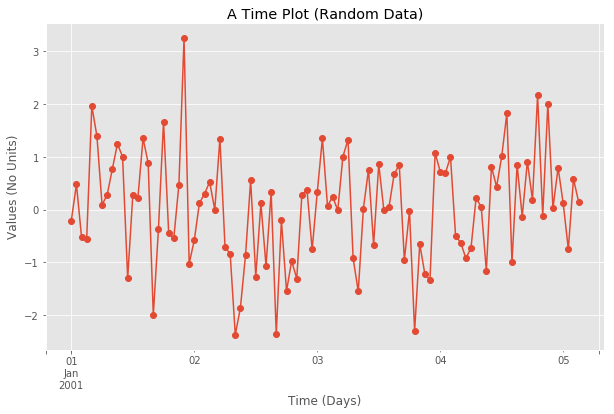

In [6]:
# A Time plot
aTimePlot = aTimeSeries.plot(style="-o", title="A Time Plot (Random Data)")
aTimePlot.set_ylabel("Values (No Units)")
aTimePlot.set_xlabel("Time (Days)")
tmp = aTimePlot.plot()

A **seasonal plot** is similar to a time plot except that the data are plotted against the individual *seasons* in which the data is observed. That is to say the same data is shown using a different time horizon or unit of time, creating simultaneous views of different time slices.

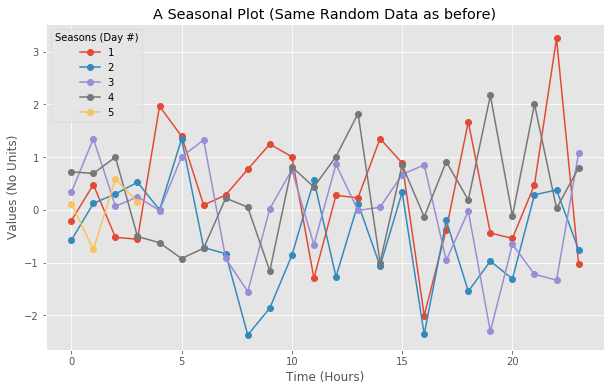

In [7]:
aTimeFrame = aTimeSeries.to_frame(name="value") # convert series to data frame
# `pivot_table` is used to make each season its own column. And, plot.
# Recall the `melt` function. This is a complementary function for reshaping data.
aSeasonalFrame = aTimeFrame.pivot_table(values="value",
                       aggfunc='sum',
                       index=aTimeFrame.index.hour, # index for units (could be aggregates)
                       columns=aTimeFrame.index.day # index for creating seasons
                      )
aSeasonalFrame.columns.name = 'Seasons (Day #)'
aSeasonalPlot = aSeasonalFrame.plot(style="-o",
                                    title="A Seasonal Plot (Same Random Data as before)")
aSeasonalPlot.set_ylabel("Values (No Units)")
aSeasonalPlot.set_xlabel("Time (Hours)")
tmp = aSeasonalPlot.plot()

A **lag plot** is a *scatter plot* comparing time series data points against themselves with a fixed delay or sequence shift. The use case for lag plots will be explained in the next section.

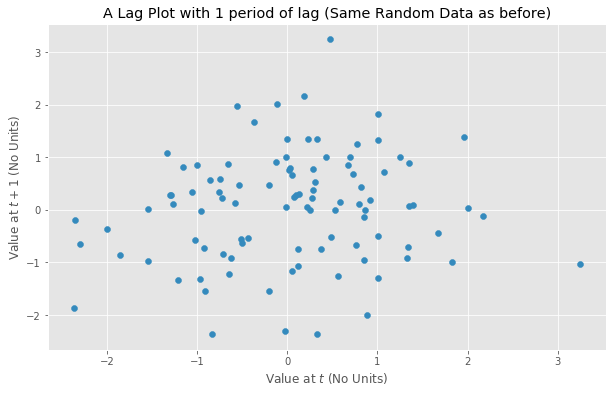

In [8]:
# pandas has a shorthand notation for constructing this type of plot.
aLagPlot = pd.plotting.lag_plot(series=aTimeSeries, lag=1)
aLagPlot.set_ylabel("Value at ${t+1}$ (No Units)")
aLagPlot.set_xlabel("Value at $t$ (No Units)")
aLagPlot.set_title("A Lag Plot with 1 period of lag (Same Random Data as before)")
None

---
## Data Assumptions and Statistical Summaries 

In this section we will discuss statistical summaries of a time series, and when they are appropriate and hold true.

Most time series methods make a simplifying assumption to ease analysis. 
The assumption is known as **stationarity**, where one assumes a time series' statistical properties (*i.e., mean, variance, growth rate*) are not varying over time. This is a sound assumption if we have adequately explained away cyclic properties and trends as separate factors.

For example, a trend line is actually a constant angle incline/decline, but it forces the mean to not be stable. So, we *decompose* the series into stable components for specific statistics. Thus, when we remove the trend from the series into a separate component, the remaining series values will become more stable for all non-trend statistical summaries.

**NOTE:** We will discuss regressions (a statistical summary of a line-of-best-fit for data points) in the next module.

<figure>
    <img src="https://upload.wikimedia.org/wikipedia/commons/e/e1/Stationarycomparison.png" alt="Comparison of two simulated processes, one stationary, one nonstationary." style="width: 62%;"/>
<figure>
    
**Image Source:** [Wikimedia commons, the free media repository, 2018](https://commons.wikimedia.org/w/index.php?title=File:Stationarycomparison.png&oldid=295046427)

*With the stationarity assumption*, it is possible to employ regular data summarizing statistics on time-series data. The most commonly used bivariate statistic is the **correlation coefficient** (discussed in the Statistics Module). Recall, the correlation coefficient measures the strength of the linear relationship between two variables. 

Based on the concept of correlation, **autocorrelation** measures the linear relationship between lagged values of a time series. There are several autocorrelation coefficients because the lag-length is left as an input variable.

$$ autocorrelation(x, lag) = cor( x_t, x_{t+lag} ) $$

Time series that show no autocorrelation are referred to as **white noise**.

### Analyzing White Noise

By definition, white noise is a stationary time series. One way to generate white noise is to use a uniformly or normally random distribution of values.

#### Time plot

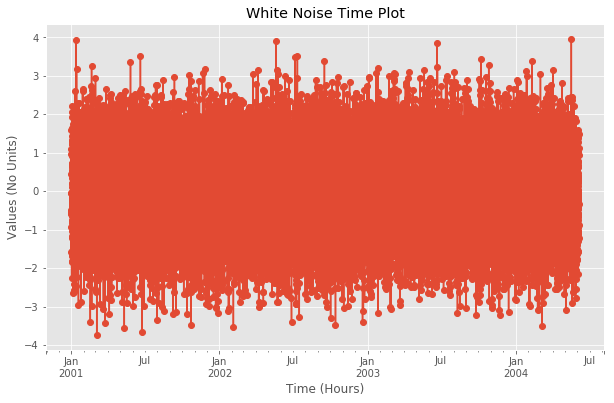

In [9]:
#Let's define and create a randomly generated stationary time series and look at the summary.
longTimeRange = pd.date_range('1/1/1', periods=30000, freq='H')
stationaryTimeSeries = pd.Series(np.random.randn(len(longTimeRange)), index=longTimeRange)

aWNTimePlot  = stationaryTimeSeries.plot(style="-o", title="White Noise Time Plot")
aWNTimePlot.set_ylabel("Values (No Units)")
aWNTimePlot.set_xlabel("Time (Hours)")
None

As stated before, the summary statistics are stable for a stationary process. What this means is that a subsample of the time series will still result in virtually the same summary statistics.

##### Full White Noise Series Summary

In [10]:
# Print to see statistical summary
stationaryTimeSeries.describe()

count    30000.000000
mean        -0.004822
std          1.000599
min         -3.745356
25%         -0.685726
50%         -0.002209
75%          0.669812
max          3.961734
dtype: float64

##### White Noise Random-Subset Series Summary

In [11]:
# Print to see statistical summary
stationaryTimeSeries.sample(n=10000).describe()

count    10000.000000
mean        -0.001209
std          1.008042
min         -3.645860
25%         -0.685212
50%          0.000419
75%          0.671530
max          3.927528
dtype: float64

#### Lag Plot

How do we know that the summaries will remain stable? It would be ridiculous to compare all possible subset statistics. 

Instead, we can compare different lags in the time series. Thus, a skew would indicate a correlation, violating stationarity. More specifically, it would indicate seasonality at that specific lag period.

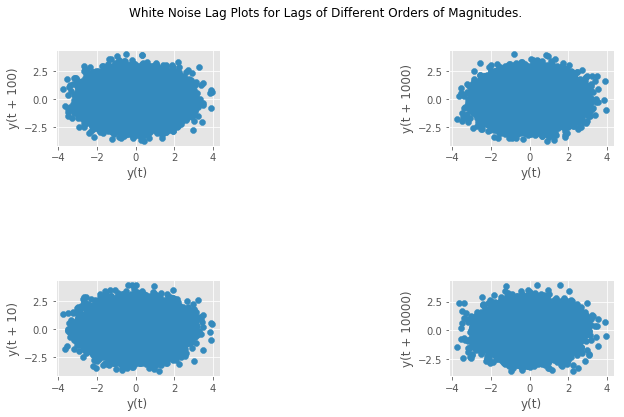

In [12]:
"""
Scatterplots of different lags further affirm this conclusion.
As you can see, there is no linear relationship visible in 
any of the lagged scatterplots.
"""
plt.subplot(3, 3, 1)
pd.plotting.lag_plot(series=stationaryTimeSeries, lag = 100)
plt.subplot(3, 3, 3)
pd.plotting.lag_plot(series=stationaryTimeSeries, lag = 1000)
plt.subplot(3, 3, 7)
pd.plotting.lag_plot(series=stationaryTimeSeries, lag = 10)
plt.subplot(3, 3, 9)
pd.plotting.lag_plot(series=stationaryTimeSeries, lag = 10000)
plt.suptitle('White Noise Lag Plots for Lags of Different Orders of Magnitudes.')
plt.show()

While the above lag periods don't appear skewed, we still have the same problem. We can't produce a new lag plot for every lag period.  

#### Autocorrelation Plot

By plotting the correlation for every lag period, we are able to finally solve the problem of detecting portions of the time series violating stationarity.

Text(0.5,0,'Lag (Hours)')

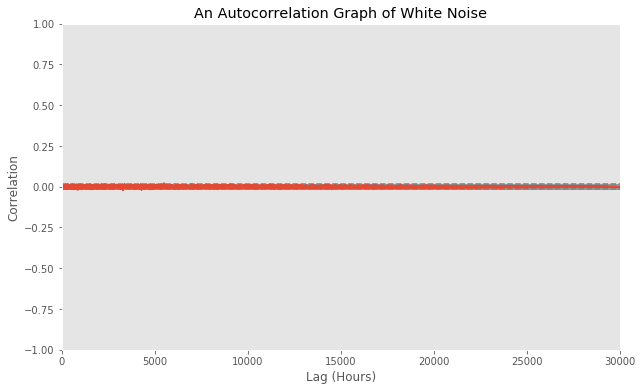

In [14]:
"""
Actual calculation of correlation for each lag value.
Looking at the prior graph, we can affirm that the observed series is white noise.
"""
aWNTimePlot = pd.plotting.autocorrelation_plot(stationaryTimeSeries)
aWNTimePlot.set_title("An Autocorrelation Graph of White Noise")
aWNTimePlot.set_ylabel("Correlation")
aWNTimePlot.set_xlabel("Lag (Hours)")


Since all lag periods have a correlation of virtually zero, we know for sure our white noise is stationary.

In our example, we already knew we were dealing with white noise. In practice, one would normally start their analysis with the autocorrelation plot first to find non-stationary subsets. Then look at those non-stationary sections with lag plots to find further patterns. 

Finally, once broken into pieces one would view the relevant sections with time plots for observing local patterns in the data.

---
## Methods

Now that we know about data summaries and data summary assumptions, *now* we can discuss how to forecast. In this section, we'll cover different methods and approaches to predict the next item in a series.

---
### Average method

This method uses the average of a data series for forecasting.

Here, the forecasts of all future values are equal to the mean/average of the historical data. If we let the historical data be denoted by $ y_1, \dots ,y_T $,
where $ y $ is the observation, $ T $ is the size of time frequencies spanned, and
$ h $ is the number of frequencies ahead being predicted, 
then we can write the forecasts as a sample mean.

$$ {\hat{y}_{T+h \mid T}} = {\dfrac {y_1 + \dots + y_T} T} $$

The notation $\hat{y}_{T+h \mid T}$ is a short-hand for the estimate of $y_{T+h}$ based on the data $y_1,\dots,y_T$.

In [15]:
timerange = pd.date_range('7/7/7', periods=70, freq='H') # Fixed frequency of hours
randomTimeSeries = pd.Series(np.random.randn(len(timerange)), index=timerange) + 10

In [16]:
randomTimeSeries.mean()

9.836958192885133

---
### Naive method

This method is only appropriate for time series data. All forecasts are simply set to be the value of the last observation. That is, the forecasts of all future values are set to be $y_T$, where $y_T$ is the last observed value. This method works remarkably well for many economic and financial time series.

In [17]:
# Need to state the amount to grab by stating the unit time

randomTimeSeries.last(offset="H")

2007-07-09 21:00:00    10.061144
Freq: H, dtype: float64

---
### Seasonal naive method

A similar method also exists for highly seasonal data. In this case, we set each forecast to be equal to the last observed value from the *same season of the year* (e.g., the same month of the previous year). 

Thus we are only looking at the last periodic interval rather than the last value of the time series.

<figure>
    <img src="https://otexts.org/fpp2/fpp_files/figure-html/beerf-1.png" alt="A comparison of the mean method, naive method and seasonal naive method for a data set that displays highly seasonal behaviour. Notice that only the seasonal naive method captures the periodic intervals in the forecast." style="width: 62%;"/>
    <figcaption> A comparison of the mean method, naive method and seasonal naive method for a data set that displays highly seasonal behaviour. Notice that only the seasonal naive method captures the periodic intervals in the forecast. Image Source: Hyndman, R.J. and Athanasopoulos, G. (2018).</figcaption>
<figure> 

In [18]:

#Technically, the last season of a time series is just grabbing values for another (larger) 
#frequency unit, but then resampling down to the original frequency unit. 
#
#In this case, let our season be every 3 hour unit in a day. 
#This is a dummy example, but a longer hourly `TimeSeries` could have been offset using days as the
#frequency of a season. 
#i.e., `"D"`

randomTimeSeries.last(offset="3H")

2007-07-09 19:00:00     7.698533
2007-07-09 20:00:00    11.003134
2007-07-09 21:00:00    10.061144
Freq: H, dtype: float64

---
### Drift method

This method is a variation on naive where we extrapolate the trend by drawing a line through the first and last observations. The amount of change over time (called the **drift**) is set to be the average change seen in the historical data. So the forecast for time $T+h$ is given by the following.

$$ 
\hat{y}_{T+h} = {y_T + {\dfrac h {T-1}}{\sum _{t=2}^T \left(y_t - y_{t-1} \right)}} = y_T + h\left( \dfrac {y_T - y_1} {T-1} \right) 
$$

This is equivalent to drawing a line between the first and last observation, and extrapolating it into the future. Unlike prior methods, this is an *estimation of growth*, rather than a future value. The growth estimate can then be applied to the last known value to obtain a forecast projection.

<figure>
    <img src="https://otexts.org/fpp2/fpp_files/figure-html/googf-1.png" alt="A comparison of the mean method, naive method and seasonal naive method for a data set that shows evidence of a trend. Notice that only the drift method captures the trend in the forecast." style="width: 62%;"/> 
    <figcaption> A comparison of the mean method, naive method and seasonal naive method for a data set that shows evidence of a trend. Notice that only the drift method captures the trend in the forecast. Image Source: Hyndman, R.J. and Athanasopoulos, G. (2018).</figcaption>
<figure> 

In [19]:
# How to calculate Drift
h = 1
numerator = randomTimeSeries.last("H")[0] - randomTimeSeries.first("H")[0]
denominator = np.size(randomTimeSeries) - 1

trendSlope = numerator / denominator

# We shift to only show valid forecasts for respective time ranges. 
# Then we grab the last value, our forecast.

# Try playing aound with `h`
(randomTimeSeries + h * trendSlope).shift(h).last(offset="H")

2007-07-09 21:00:00    10.999923
Freq: H, dtype: float64

---
## Adjustments and Transformations

The purpose of adjustments and transformations are essentially cleaning up or preparing data, reducing noise, or correcting the context. In this section we'll discuss the following adjustments:

* Calendar
* Population
* Inflation

We will then talk about the use of logarithms (or powers) to ease analysis.

The purpose of all these adjustments and transformations are to simplify the patterns in historical data by removing known
sources of variation or by making patterns more consistent across the whole data set. Simpler patterns usually lead to more
accurate forecasts.

---
### Adjustments

Adjustments are usually applied prior to transformations and are meant to normalize data for the purpose of usability with other data sources.

In [20]:
#Code setup to download data sets
def download_file(url):
    local_filename = url.split('/')[-1]
    r = requests.get(url, stream=True)
    with open(local_filename, 'wb') as f:
        for chunk in r.iter_content(chunk_size=1024): 
            if chunk: 
                f.write(chunk)
    return local_filename

---
#### Calendar 

Calendar adjustments refer to variation seen in *seasonal* data due to simple calendar effects (i.e., Months don't have the same number of days.). In such cases, it is usually much easier to remove the variation before fitting a forecasting model (i.e., re-calculate time series with a consistent time interval between measures).

For our purposes, we will be using a dataset of order demands to demonstrate. (Ferrera, Martiniano, Ferreira, Ferreira and Sassi, 2016).

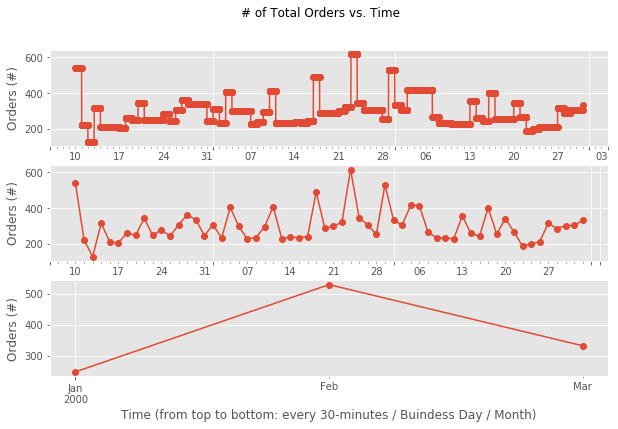

In [21]:
#Downloading Dataset

csvUrl = "https://archive.ics.uci.edu/ml/machine-learning-databases/00409/Daily_Demand_Forecasting_Orders.csv"
## NOTE: The source will block you if you download too often.
csvFile = download_file(csvUrl)
csvFile = "Daily_Demand_Forecasting_Orders.csv"

#Reading dataset into pandas dataframe
df = pd.read_csv(csvFile, sep=";")

# Fixed frequency of business days. Arbitrary date.
timerange = pd.date_range('1/10/0', periods=len(df.iloc[:, 12]), freq='B')
demandSeries = pd.Series(np.array(df.iloc[:, 12]), index=timerange)


#Plotting data

plt.subplot(3, 1, 1)

#Note how the cycling is incorrectly represented as seasonality.
demandPlot = demandSeries.asfreq(freq='30T', method='pad').plot(style="-o")
demandPlot.set_ylabel("Orders (#)")
demandPlot.set_xlabel("Time (Business Days)")
demandPlot.plot()

plt.subplot(3, 1, 2)

demandPlot2 = demandSeries.plot(style="-o")
demandPlot2.set_ylabel("Orders (#)")
demandPlot2.set_xlabel("Time (Business Days)")
demandPlot2.plot()

plt.subplot(3, 1, 3)

#Note how more of the trend is coming through.
demandPlot3 = demandSeries.asfreq(freq='M', method='pad').plot(style="-o")
demandPlot3.set_ylabel("Orders (#)")
demandPlot3.set_xlabel("Time (from top to bottom: every 30-minutes / Buindess Day / Month)")
demandPlot3.plot()

plt.suptitle('# of Total Orders vs. Time')

plt.show()

Here the same data is being displayed, but adjusted for different frequencies / periods. Larger periods (months) show more of the trend while smaller periods expose visually more seasonality.

---
#### Population 

Any data that are affected by population changes can be adjusted to give per-capita data. That is, consider the data per person (or per thousand people, or per million people) rather than the total.  For most data that are affected by population changes, it is best to use per-capita data rather than the totals.

For our purposes, we will be using a dataset of Population counts and Gross Domestic Product from the United Nations and World Bank to demonstrate. (Github Contributors, 2018a; Github Contributors, 2018b)

In [22]:
# Get GDP Data
csvUrl = "https://raw.githubusercontent.com/datasets/gdp/master/data/gdp.csv"
csvFile = download_file(csvUrl)
csvFile = "gdp.csv"

df = pd.read_csv(csvFile)
canDFgdp = df[df.loc[:]["Country Name"] == "Canada"]

# Get Population Data
csvUrl = "https://raw.githubusercontent.com/datasets/population/master/data/population.csv"
csvFile = download_file(csvUrl)
csvFile = "population.csv"
df2 = pd.read_csv(csvFile)
canDFpop = df2[df2.loc[:]["Country Name"] == "Canada"]

#Read time correctly
canDFgdp.iloc[:]["Year"] = pd.to_datetime(canDFgdp.iloc[:]["Year"], format='%Y')
canDFpop.iloc[:]["Year"] = pd.to_datetime(canDFpop.iloc[:]["Year"], format='%Y')

[]

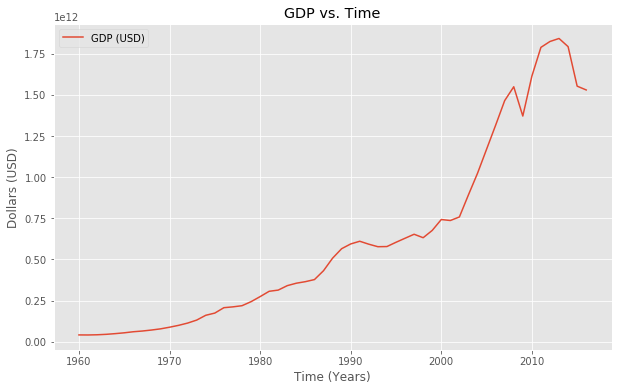

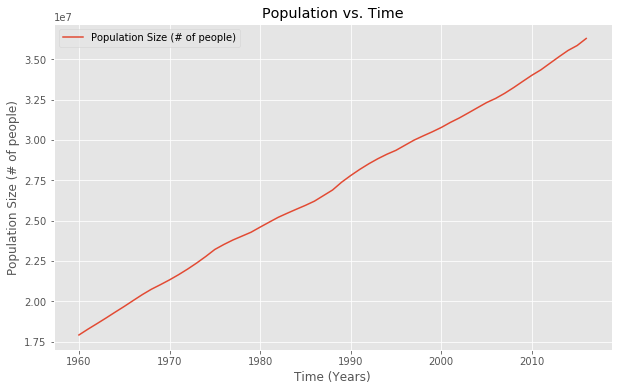

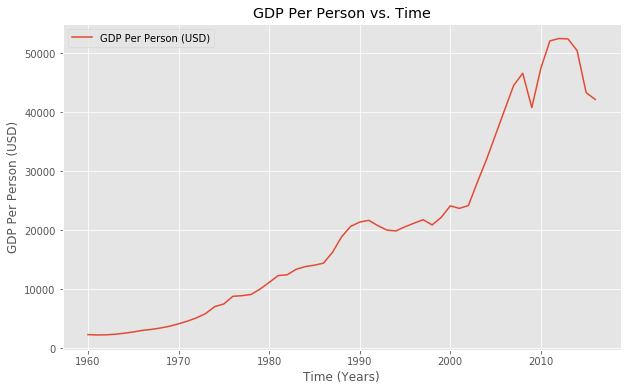

In [23]:
#Calculate GDP per person
canDFgdpPerPerson = canDFgdp.merge(canDFpop, on="Year")
canDFgdpPerPerson["GDP Per Person (USD)"] = (canDFgdpPerPerson["Value_x"]).divide(canDFgdpPerPerson["Value_y"])
canDFgdpPerPerson["GDP (USD)"] = canDFgdpPerPerson["Value_x"]
canDFgdpPerPerson["Population Size (# of people)"] = canDFgdpPerPerson["Value_y"]

##Plot

#GDP
canDFgdpPerPersonPlot = canDFgdpPerPerson.plot(x="Year", y="GDP (USD)")
canDFgdpPerPersonPlot.set_title("GDP vs. Time")
canDFgdpPerPersonPlot.set_ylabel("Dollars (USD)")
canDFgdpPerPersonPlot.set_xlabel("Time (Years)")
canDFgdpPerPersonPlot.plot()
# population
canDFgdpPerPersonPlot = canDFgdpPerPerson.plot(x="Year", y="Population Size (# of people)")
canDFgdpPerPersonPlot.set_title("Population vs. Time")
canDFgdpPerPersonPlot.set_ylabel("Population Size (# of people)")
canDFgdpPerPersonPlot.set_xlabel("Time (Years)")
canDFgdpPerPersonPlot.plot()
# GDP per person 
# **NOTE:** Pay attention to the scales (top-left-corner of plot), and not just the y-values
canDFgdpPerPersonPlot = canDFgdpPerPerson.plot(x="Year", y="GDP Per Person (USD)")
canDFgdpPerPersonPlot.set_title("GDP Per Person vs. Time")
canDFgdpPerPersonPlot.set_ylabel("GDP Per Person (USD)")
canDFgdpPerPersonPlot.set_xlabel("Time (Years)")
canDFgdpPerPersonPlot.plot()


---
#### Inflation 

Data that are affected by the value of money are best adjusted before modeling.  For this reason, financial time series are usually adjusted so all values are stated in dollar values from a particular year or known point of reference. 

To make these adjustments a *price index* is used. If $z_t$ denotes the price index and $y_t$ denotes an original house price in year $t$, then 

$$
x_t = {\dfrac {y_t} {z_t}} \times z_{reference}
$$

gives the adjusted  price at the reference year's dollar value. 

---
**NOTE**: 
* Price indexes are often constructed by government agencies. For consumer goods, a common price index is the *Consumer Price Index* (or CPI).
* Both Population and Inflation cases are simply the multiplication or division of two Time-series in order to obtain comparable data or achieving appropriate units, which `pandas` allows. Only an equivalent index frequency is needed, which we have demonstrated multiple above.

---
### Mathematical transformations

When the standard deviance fluctuates across a time series, it can be difficult to decompose. A transformation can be useful in this situation. 

A **logarithmic transformation** is most commonly used. If we denote the original observations as $ y_1, \dots, y_T $ and the transformed observations as $ w_1,\dots,w_T $ then the applied transformation is as follows.

$$ 
w_t=log(y_t) 
$$ 

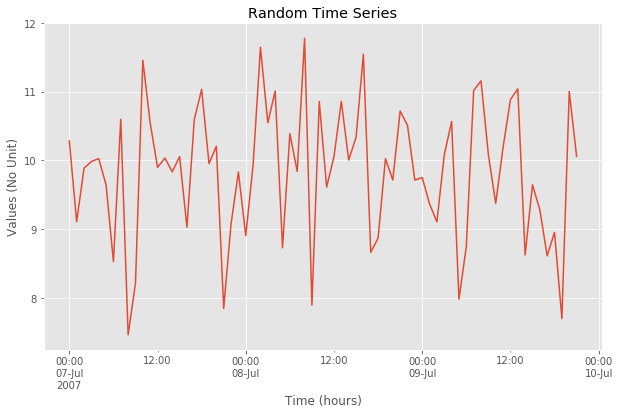

In [24]:
# Applying a log transformation
logTimeSeries = np.log(randomTimeSeries)
randomPlot = randomTimeSeries.plot(title="Random Time Series")
randomPlot.set_xlabel("Time (hours)")
randomPlot.set_ylabel("Values (No Unit)")
None

Text(0,0.5,'Logarithmic Values (No Unit)')

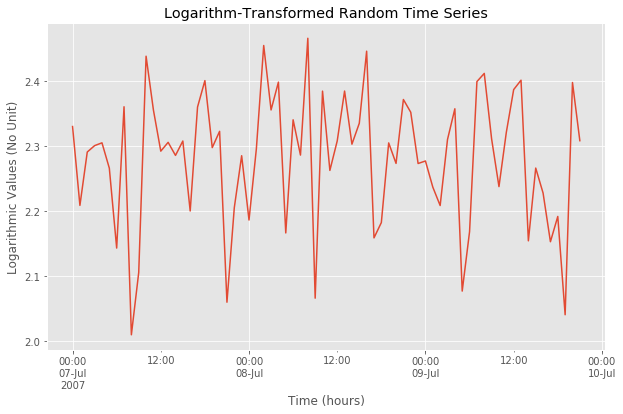

In [33]:
randomLogPlot = logTimeSeries.plot(title="Logarithm-Transformed Random Time Series")
randomLogPlot.set_xlabel("Time (hours)")
randomLogPlot.set_ylabel("Logarithmic Values (No Unit)")
#None

Logarithms are useful because they are interpretable. Changes in a $ log $ value are relative changes on the original scale and stay positive on the original scale. i.e.,  

$$ 
log_{10}\left(x\right) + c \propto 10 c \times x 
$$

Sometimes other transformations are also used (although they are not so interpretable). For example, square roots and cube roots can be used. These are called **power transformations**.

$$ 
w_t=y ^p _t 
$$

The family of transformations that includes logarithms and power transformations is known as **Box-Cox transformations**, which depend on the parameter $\lambda$ and are defined as follows.

* if $ \lambda = 0 $ then, $$ 
w_t = ln(y_t) = log _e (y_t)
$$
* otherwise, $$ 
w_t = \dfrac{y^\lambda _t - 1}{\lambda} 
$$

In [32]:
# Sum of Box-Cox transformation for $lambda = [0, 1, 2]$
ourLambda = 2
boxTimeSeries = randomTimeSeries.pow(ourLambda).subtract(1).div(ourLambda)
boxTimeSeries
#None

2007-07-07 00:00:00    52.366678
2007-07-07 01:00:00    40.982346
2007-07-07 02:00:00    48.384044
2007-07-07 03:00:00    49.352497
2007-07-07 04:00:00    49.782390
2007-07-07 05:00:00    46.011995
2007-07-07 06:00:00    35.879122
2007-07-07 07:00:00    55.684129
2007-07-07 08:00:00    27.363075
2007-07-07 09:00:00    33.250280
                         ...    
2007-07-09 12:00:00    58.727708
2007-07-09 13:00:00    60.464775
2007-07-09 14:00:00    36.698039
2007-07-09 15:00:00    46.026563
2007-07-09 16:00:00    42.586342
2007-07-09 17:00:00    36.595710
2007-07-09 18:00:00    39.594233
2007-07-09 19:00:00    29.133701
2007-07-09 20:00:00    60.034479
2007-07-09 21:00:00    50.113305
Freq: H, Length: 70, dtype: float64

Having chosen a transformation, we forecast the transformed data. Then, we need to reverse the transformation (or **back-transform**) to obtain forecasts on the original scale. The reverse Box-Cox transformation is given by the following.

* if $\lambda = 0$ then, $$ 
y_t = e ^ {w_t} 
$$
* otherwise, $$
y_t = \left(\lambda w _t + 1 \right) ^ {1 / \lambda} 
$$

In [30]:
boxTimeSeries.multiply(ourLambda).add(1).pow(1/ourLambda)
#None

2007-07-07 00:00:00    10.282673
2007-07-07 01:00:00     9.108496
2007-07-07 02:00:00     9.887775
2007-07-07 03:00:00     9.985239
2007-07-07 04:00:00    10.028199
2007-07-07 05:00:00     9.644894
2007-07-07 06:00:00     8.529844
2007-07-07 07:00:00    10.600390
2007-07-07 08:00:00     7.464995
2007-07-07 09:00:00     8.215872
                         ...    
2007-07-09 12:00:00    10.883722
2007-07-09 13:00:00    11.042171
2007-07-09 14:00:00     8.625316
2007-07-09 15:00:00     9.646405
2007-07-09 16:00:00     9.282924
2007-07-09 17:00:00     8.613444
2007-07-09 18:00:00     8.954801
2007-07-09 19:00:00     7.698533
2007-07-09 20:00:00    11.003134
2007-07-09 21:00:00    10.061144
Freq: H, Length: 70, dtype: float64

In [31]:
np.exp(logTimeSeries)
#None

2007-07-07 00:00:00    10.282673
2007-07-07 01:00:00     9.108496
2007-07-07 02:00:00     9.887775
2007-07-07 03:00:00     9.985239
2007-07-07 04:00:00    10.028199
2007-07-07 05:00:00     9.644894
2007-07-07 06:00:00     8.529844
2007-07-07 07:00:00    10.600390
2007-07-07 08:00:00     7.464995
2007-07-07 09:00:00     8.215872
                         ...    
2007-07-09 12:00:00    10.883722
2007-07-09 13:00:00    11.042171
2007-07-09 14:00:00     8.625316
2007-07-09 15:00:00     9.646405
2007-07-09 16:00:00     9.282924
2007-07-09 17:00:00     8.613444
2007-07-09 18:00:00     8.954801
2007-07-09 19:00:00     7.698533
2007-07-09 20:00:00    11.003134
2007-07-09 21:00:00    10.061144
Freq: H, Length: 70, dtype: float64

---
#### Features of power transformations

* If $ y_t \leq 0 $, no power transformation is possible unless all observations are adjusted by adding a constant to all values.
* Simple values for $ \lambda $ makes explanations easier.
* Often no power transformation is needed.
    * $ \lambda $ must be empirically determined. The best value is the one that produces the most stationary time series as its output.

---
#  Additional Resources

* Brodersen, H., Gallusser, F., Kay, H. & Keohler, J. (2015). _Inferring causal impact using bayesian structural time-series models_'', Annals of Applied Statistics, vol. 9, number , pp. 247-274.  [online](https://ai.google/research/pubs/pub41854)
* Broderson, H. & Kay, H. (2014). _Causalimpact: a new open-source package for estimating causal effects in time series | google open source blog_.  [online](https://opensource.googleblog.com/2014/09/causalimpact-new-open-source-package.html)
* Hilpisch, Y. (2014). _Python for finance: analyze big financial data_.
* Natrella, M. (2013).  ``_Nist/sematech e-handbook of statistical methods_'', October 2013.  [online](https://www.itl.nist.gov/div898/handbook/eda/section3/autocopl.htm)
* Sargent, T. & Stachurski, J. (2017). ``_Quantitative economics_'',  2017.  [online](https://lectures.quantecon.org/py/index.html)
* Shumway, R.H. and D. S. Stoffer, D.S. (2017). ``_Time series analysis using the r statistical package_'',  2017.  [online](http://www.stat.pitt.edu/stoffer/tsa4/tsaEZ.pdf)
* Srivastava, T. (2015). ``_A complete tutorial on time series modeling in r_'', December 2015.  [online](https://www.analyticsvidhya.com/blog/2015/12/complete-tutorial-time-series-modeling/)
* Ulrich, J. (2018). ``_Foss trading_''.  [online](http://blog.fosstrading.com/)

# References

Hyndman, R.J. & Athanasopoulos, G. (2018). _Forecasting: principles and practice, 2nd Ed._.  [online](https://www.otexts.org/fpp2)

Ferrera, R.P., Martiniano, A., Ferreira, Andrea, Ferreira, Aleister, and Sassi, R.J. (2016). ``_Study on daily demand forecasting orders using artificial neural network_'', IEEE Latin America Transactions, vol. 14, number 3, pp. 1519--1525,  2016.  [online](http://archive.ics.uci.edu/ml/datasets/Daily+Demand+Forecasting+Orders#)

Github Contributors, 2018a. ``_Github - datasets/gdp: country, regional and world gdp in current us dollars (\$)_'', March 2018.  [online](https://github.com/datasets/gdp)

Github Contributors, 2018b. ``_Github - datasets/population: population figures for countries, regions (e.g. asia) and the world._'', June 2018.  [online](https://github.com/datasets/population)
